In [18]:
# Import necessary packages
using SparseArrays
using StaticArrays
using LinearAlgebra
using IterativeSolvers
using AlgebraicMultigrid
using Printf

include("Grid.jl")
include("Stokes.jl")

unpack (generic function with 1 method)

In [19]:
# Definitions of Marker and Markers
mutable struct Marker
    x::MVector{2,Float64}# mutable but fixed-size vector of coordinates
    cell::MVector{2,Int16}# cell in which the marker is located
    rho::Float64
    eta::Float64
    function Marker()
       new(MVector{2,Float64}(-1.,-1.),MVector{2,Int16}(-1,-1),0.0) 
    end
end

mutable struct Markers
    # Currently, the markers only contains the array of markers and the number of markers in the array.
    m::Array{Marker,1}
    nmark::Int64
    function Markers(n::Integer)
       new( Array{Marker,1}(undef,n),0)
    end
    function Markers(grid::CartesianGrid; nmx::Integer=5,nmy::Integer=5)
       # distribute markers uniformly in the domain 
        # nmx and nmy are the number of markers per cell in the x and y directions, respectively.
        N = nmx*nmy*grid.nx*grid.ny # total number of markers
        mm = Array{Marker,1}(undef,N)
        mdx = grid.W/nmx/(grid.nx-1)
        mdy = grid.H/nmy/(grid.ny-1)
        k=1
        for i in 1:(grid.ny-1)
            for j in 1:(grid.nx-1)
                for ii in 1:nmy
                    for jj in 1:nmx
                        mm[k] = Marker()
                        mm[k].x[1] = mdx/2. + mdx*(jj-1) + mdx*nmx*(j-1)
                        mm[k].x[2] = mdy/2. + mdy*(ii-1) + mdy*nmy*(i-1) 
                        mm[k].cell[1] = j
                        mm[k].cell[2] = i
                        mm[k].rho = 0.
                        k+=1
                    end
                end
            end
        end
        new(mm,k-1)
    end
end

In [87]:
function find_cell(x::Float64,gridx::Vector{Float64},nx::Int ; guess::Integer=nothing)
    # find the cell in the array gridx that contains the current marker
    # first, see whether the initial guess is correct.
    lower::Int = 1
    upper::Int = nx
    if guess != nothing && guess >= 1 && guess < nx
        if x >= gridx[guess] && x < gridx[guess+1]
            return guess
        else
            if x>=gridx[guess+1]
                lower = guess
            else
                upper = guess+1
            end
        end
     end
    # locate cell using bisection on lower,upper
    while upper-lower > 1 
        midpoint::Int = lower + floor((upper-lower)/2)
        if x >= gridx[midpoint]
            lower = midpoint
        else
            upper = midpoint
        end
    end
    return lower
end

function find_cells!(markers::Markers,grid::CartesianGrid)
   for i in 1:markers.nmark
        markers.m[i].cell[1] = find_cell(markers.m[i].x[1] , grid.x, grid.nx, guess=markers.m[i].cell[1])
        markers.m[i].cell[2] = find_cell(markers.m[i].x[2] , grid.y, grid.ny, guess=markers.m[i].cell[2])
    end
end

function initial_density!(markers::Markers)
    for i in 1:markers.nmark
        mx = markers.m[i].x[1]
        markers.m[i].rho = mx >= 200e3 && mx <= 300e3 ? 3200. : 3300.
    end
end

function marker_to_basic_node(markers::Markers,grid::CartesianGrid)
    weights = zeros(grid.ny,grid.nx)
    weighted_sum = zeros(grid.ny,grid.nx)
    # loop over the markers
    m = markers.m
    for i in 1:markers.nmark
       # calculate weights for four surrounding basic nodes
         cellx = m[i].cell[1]
         celly = m[i].cell[2]
         wx = (m[i].x[1] - grid.x[cellx])/(grid.x[cellx+1]-grid.x[cellx]) # mdx/dx
         wy = (m[i].x[2] - grid.y[celly])/(grid.y[celly+1]-grid.y[celly])
         #i,j
         weighted_sum[celly,cellx] += (1.0-wx)*(1.0-wy)*m[i].rho
         weights[celly,cellx]      += (1.0-wx)*(1.0-wy)
         #i+1,j
         weighted_sum[celly+1,cellx] += (1.0-wx)*(wy)*m[i].rho
         weights[celly+1,cellx]      += (1.0-wx)*(wy)
         #i,j+1
         weighted_sum[celly,cellx+1] += (wx)*(1.0-wy)*m[i].rho
         weights[celly,cellx+1]      += (wx)*(1.0-wy)
         #i+1,j+1
         weighted_sum[celly+1,cellx+1] += (wx)*(wy)*m[i].rho
         weights[celly+1,cellx+1]      += (wx)*(wy)        
    end
    weighted_sum = weighted_sum ./ weights
    return weighted_sum
end

function basic_node_to_markers!(markers::Markers,grid::CartesianGrid,field::Matrix)
    m = markers.m
    for i in 1:markers.nmark
        cellx::Integer = m[i].cell[1]
        celly::Integer = m[i].cell[2]
        wx::Float64 = (m[i].x[1] - grid.x[cellx])/(grid.x[cellx+1]-grid.x[cellx]) # mdx/dx
        wy::Float64 = (m[i].x[2] - grid.y[celly])/(grid.y[celly+1]-grid.y[celly])
        
        markers.m[i].rho = (1.0-wx)*(1.0-wy)*field[celly,cellx] +
            + (wx)*(1.0-wy)*field[celly,cellx+1] +
            + (1.0-wx)*(wy)*field[celly+1,cellx] +
            + (wx)*(wy)*field[celly+1,cellx+1]
    end
end

function velocity_to_centers(grid::CartesianGrid,vx::Matrix,vy::Matrix)
     vxc = zeros(grid.ny+1,grid.nx+1);
     vyc = zeros(grid.ny+1,grid.nx+1);
     # cell centers are offset in (-) direction from basic nodes.
     for i in 1:grid.ny+1        
        for j in 1:grid.nx+1
            vxm = j==1 ? 0.0 : vx[i,j-1]
            vxp = vx[i,j]
            vym = i==1 ? 0.0 : vy[i-1,j]
            vyp = vy[i,j]
            vxc[i,j] = 0.5*(vxp+vxm)
            vyc[i,j] = 0.5*(vyp+vym)            
        end
    end
    return vxc,vyc
end

function velocity_to_markers(markers::Markers,grid::CartesianGrid,vxc::Matrix,vyc::Matrix)
    # This function expects the velocities to be defined at the cell centers. vxc and vyc should each have
    # an 'extra' column and row corresponding to the ghost degrees of freedom that are needed to interpolate
    # velocities along the bottom and left of the domain.
    mvx = [0.0 for i in 1:markers.nmark] # velocities at marker locations
    mvy = [0.0 for i in 1:markers.nmark]
    # interpolate x-velocity
    for i in 1:markers.nmark
        m::Marker = markers.m[i]
        cellx = m.x[1] < grid.xc[m.cell[1]+1] ? m.cell[1] : m.cell[1] + 1
        celly = m.x[2] < grid.yc[m.cell[2]+1] ? m.cell[2] : m.cell[2] + 1
        mdx = (m.x[1] - grid.xc[cellx])/(grid.xc[cellx+1]-grid.xc[cellx])
        mdy = (m.x[2] - grid.yc[celly])/(grid.yc[celly+1]-grid.yc[celly])
        mvx[i] = (1-mdx)*(1-mdy)*vxc[celly,cellx] +
            + (mdx)*(1-mdy)*vxc[celly,cellx+1] +
            + (1-mdx)*(mdy)*vxc[celly+1,cellx] +
            + (mdx)*(mdy)*vxc[celly+1,cellx+1]
        mvy[i] = (1-mdx)*(1-mdy)*vyc[celly,cellx] +
            + (mdx)*(1-mdy)*vyc[celly,cellx+1] +
            + (1-mdx)*(mdy)*vyc[celly+1,cellx] +
            + (mdx)*(mdy)*vyc[celly+1,cellx+1]
    end    
    return mvx,mvy
end

function move_markers!(markers::Markers,grid::CartesianGrid,vxc::Matrix,vyc::Matrix)
    # compute velocities for each marker
    mvx,mvy = velocity_to_markers(markers,grid,vxc,vyc)
    # determine the maximal timestep
    vxmax = maximum(abs.(mvx))
    vymax = maximum(abs.(mvy))
    dt = max( 0.5*grid.dx/vxmax, 0.5*grid.dy/vymax )
    for i in 1:markers.nmark
        markers.m[i].x += dt*[mvx[i],mvy[i]]
    end
    # what to do if markers leave domain?
    find_cells!(markers,grid)
end

move_markers! (generic function with 1 method)

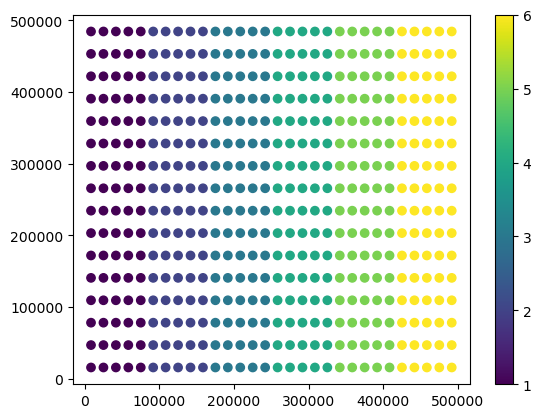

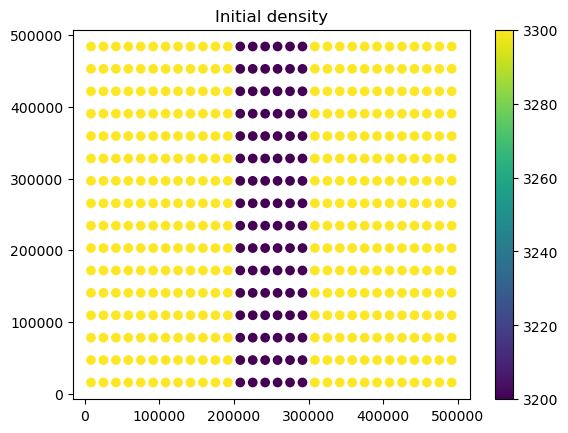

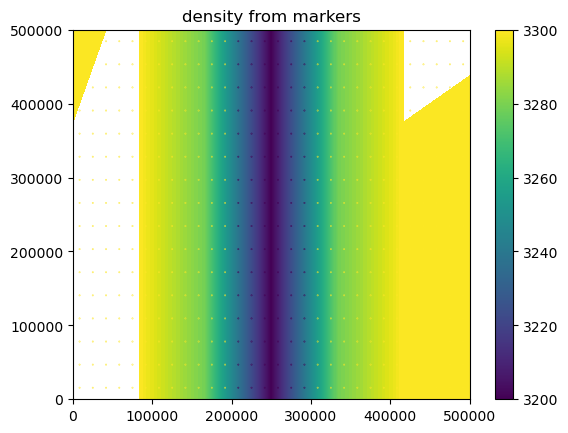

In [100]:
# Diagnostic tests on marker routines:
# Set up a grid and some markers
nx = 7
ny = 5
W = 5e5
H = 5e5
gy = -10.0
gx =  0.0
markx = 5
marky = 4
grid = CartesianGrid(W,H,nx,ny)
markers = Markers(grid;nmx=markx,nmy=marky)

mx = [markers.m[i].x[1] for i in 1:markers.nmark]
my = [markers.m[i].x[2] for i in 1:markers.nmark]
mcx = [markers.m[i].cell[1] for i in 1:markers.nmark]
mcy = [markers.m[i].cell[2] for i in 1:markers.nmark]

using PyPlot
figure()
scatter(mx,my,c=mcx)
colorbar()
show()

initial_density!(markers)

figure()
mrho = [markers.m[i].rho for i in 1:markers.nmark]
scatter(mx,my,c=mrho)
title("Initial density")
colorbar()
show()


rho_node = marker_to_basic_node(markers,grid)

figure()
contourf(grid.x,grid.y,rho_node,100)
mrho = [markers.m[i].rho for i in 1:markers.nmark]
scatter(mx,my,c=mrho,s=0.1)
title("density from markers")
colorbar()
show()

basic_node_to_markers!(markers,grid,rho_node)

# figure()
# mrho = [markers.m[i].rho for i in 1:markers.nmark]
# scatter(mx,my,c=mrho)
# title("Rho post-interpolation")
# colorbar()
# show()

In [99]:
rho_node

5×7 Matrix{Float64}:
 3300.0  3300.0  3282.0  3216.0  3282.0  3300.0  3300.0
 3300.0  3300.0  3282.0  3216.0  3282.0  3300.0  3300.0
 3300.0  3300.0  3282.0  3216.0  3282.0  3300.0  3300.0
 3300.0  3300.0  3282.0  3216.0  3282.0  3300.0  3300.0
 3300.0  3300.0  3282.0  3216.0  3282.0  3300.0  3300.0

In [103]:
# Set up the grid
nx = 51
ny = 51
W = 5e5
H = 5e5
gy = 10.0
gx =  0.0
markx = 5
marky = 5
grid = CartesianGrid(W,H,nx,ny)
markers = Markers(grid ; nmx=markx,nmy=marky)
# Initial conditions
initial_density!(markers)

for itime in 1:20
    # density  markers -> nodes
    rho = marker_to_basic_node(markers,grid)
    eta_s = 1e21 .* ones(grid.ny,grid.nx)
    eta_n = 1e21 .* ones(grid.ny,grid.nx)

    # rho,eta_s,eta_n = initial_conditions(grid)
    bc = BoundaryConditions(0,0,0,0)
    @time L,R = form_stokes(grid,eta_s,eta_n,rho,bc,gx,gy)
    @time solution = L\R
    @time vx,vy,P = unpack(solution,grid;ghost=true)
    @time vxc,vyc = velocity_to_centers(grid,vx,vy)
    #mvx,mvy = velocity_to_markers(markers,grid,vxc,vyc)
    @time move_markers!(markers,grid,vxc,vyc)
end

  0.042277 seconds (397.95 k allocations: 9.957 MiB, 55.83% gc time)
  0.067531 seconds (71 allocations: 18.736 MiB)
  0.000050 seconds (10 allocations: 63.641 KiB)
  0.000035 seconds (7 allocations: 42.438 KiB)
  0.119387 seconds (3.06 M allocations: 57.205 MiB)
  0.014001 seconds (397.95 k allocations: 9.957 MiB)
  0.066840 seconds (71 allocations: 18.736 MiB)
  0.000047 seconds (10 allocations: 63.641 KiB)
  0.000037 seconds (7 allocations: 42.438 KiB)
  0.128700 seconds (3.06 M allocations: 57.205 MiB)
  0.014095 seconds (397.95 k allocations: 9.957 MiB)
  0.065833 seconds (71 allocations: 18.736 MiB)
  0.000045 seconds (10 allocations: 63.641 KiB)
  0.000032 seconds (7 allocations: 42.438 KiB)
  0.255320 seconds (3.06 M allocations: 57.205 MiB, 46.03% gc time)
  0.017291 seconds (397.95 k allocations: 9.957 MiB)
  0.065734 seconds (71 allocations: 18.736 MiB)
  0.000044 seconds (10 allocations: 63.641 KiB)
  0.000033 seconds (7 allocations: 42.438 KiB)
  0.293308 seconds (3.06 M a

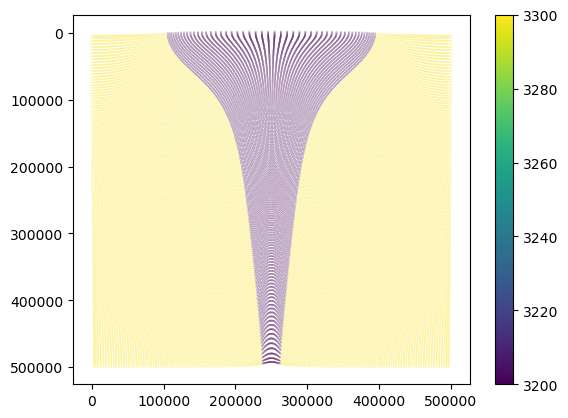

In [107]:
mx = [markers.m[i].x[1] for i in 1:markers.nmark]
my = [markers.m[i].x[2] for i in 1:markers.nmark]
mrho = [markers.m[i].rho for i in 1:markers.nmark]
figure()
scatter(mx,my,c=mrho,s=0.01)
gca().invert_yaxis()
colorbar()
show()

In [110]:
vy[1,:]


52-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [75]:

maximum(abs.(mvx))

1.1759302234958616e-9

In [11]:
print(grid.y)
print("\n")
print(grid.yc)

[0.0, 10204.08163265306, 20408.16326530612, 30612.244897959183, 40816.32653061224, 51020.40816326531, 61224.489795918365, 71428.57142857142, 81632.65306122448, 91836.73469387756, 102040.81632653062, 112244.89795918367, 122448.97959183673, 132653.0612244898, 142857.14285714284, 153061.22448979592, 163265.30612244896, 173469.38775510204, 183673.46938775512, 193877.55102040817, 204081.63265306124, 214285.71428571426, 224489.79591836734, 234693.8775510204, 244897.95918367346, 255102.04081632654, 265306.1224489796, 275510.2040816326, 285714.2857142857, 295918.36734693876, 306122.44897959183, 316326.5306122449, 326530.61224489793, 336734.693877551, 346938.7755102041, 357142.85714285716, 367346.93877551024, 377551.02040816325, 387755.10204081633, 397959.1836734694, 408163.2653061225, 418367.3469387755, 428571.4285714285, 438775.5102040816, 448979.5918367347, 459183.67346938775, 469387.7551020408, 479591.83673469385, 489795.9183673469, 500000.0]
[-5102.040816326531, 5102.040816326531, 15306.12

In [78]:
    dt = max(1,2)

2